# Run torsion scans

In [2]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools import states
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys
from openmmtools.constants import kB
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTState

logger = logging.getLogger()
logger.setLevel(logging.INFO)


### Define helper function for alchemifying

In [11]:
def alchemify(htf, endstate):
    
    # Define simulation parameters
    nsteps = 10000
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions
    
    # Build REST factory
    factory = RESTTopologyFactory(system, solute_region=list(range(6, 20)) + [0, 1, 20, 22])

    # Get REST system
    REST_system = factory.REST_system
    
    # Create thermostate
    T_min = 298.0*unit.kelvin
    temperature = 600.0*unit.kelvin
    lambda_zero_alchemical_state = RESTState.from_system(REST_system)
    thermostate = ThermodynamicState(REST_system, temperature=temperature)
    compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])
    
    # Set alchemical parameters
    beta_0 = 1/(kB*T_min)
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state.set_alchemical_parameters(beta_0, beta_m)
    
    # Create sampler state
    sampler_state =  SamplerState(positions, box_vectors=system.getDefaultPeriodicBoxVectors())

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = compound_thermodynamic_state.create_context(integrator, platform=platform)    

    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(compound_thermodynamic_state.reduced_potential(context))
    
#     md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

#     # Run equilibration
#     for step in tqdm(range(nsteps)):
#         integrator.step(1)
    
    return context, compound_thermodynamic_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [4]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Create context, compound state
    context, compound_state = alchemify(htf, endstate)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(compound_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(compound_state, sampler_state)
        
        sampler_state.apply_to_context(context)
        energy = compound_state.reduced_potential(context)
        energies = [energy]
#         openmm.LocalEnergyMinimizer.minimize(context)
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         compound_state.system.setParticleMass(index, d_masses[index])
#     compound_state.apply_to_context(context)
    
    return d_corrected
    
    

In [5]:
torsion_scans = []

## THR->ALA r-htf in vacuum (flattened torsions and exceptions) @ lambda = 0, REST2

In [2]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/11/0/"

with open(os.path.join(data_dir, f"0_vacuum_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)


In [3]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-C 0
ACE1-O 1
ACE1-CH3 2
ACE1-H1 3
ACE1-H2 4
ACE1-H3 5
THR2-N 6
THR2-CA 7
THR2-C 8
THR2-O 9
THR2-CB 10
THR2-CG2 11
THR2-OG1 12
THR2-H 13
THR2-HA 14
THR2-HB 15
THR2-HG1 16
THR2-HG21 17
THR2-HG22 18
THR2-HG23 19
THR2-CB 26
THR2-HB1 27
THR2-HB2 28
THR2-HB3 29
NME3-N 20
NME3-C 21
NME3-H 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [4]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (CA) of chain 0 residue 1 (THR)> 7
<Atom 8 (C) of chain 0 residue 1 (THR)> 8
<Atom 9 (O) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (CG2) of chain 0 residue 1 (THR)> 11
<Atom 12 (OG1) of chain 0 residue 1 (THR)> 12
<Atom 13 (H) of chain 0 residue 1 (THR)> 13
<Atom 14 (HA) of chain 0 residue 1 (THR)> 14
<Atom 15 (HB) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG1) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG21) of chain 0 residue 1 (THR)> 17
<Atom 18 (HG22) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG23) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (C) of chain 0 residue 2 (NME)> 21
<Atom 22 (H) of chain 0 resi

INFO:REST:No MonteCarloBarostat added.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:REST:No unknown forces.


-25.46266581702266
3.0071301
-79.53650874549983


INFO:root:Rotating by -0.02548131905831008 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000007 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26200000000000007 rad

-79.50423663246816
-77.5398176726603
-71.66326330460367
-63.669768211434075
-56.81138397112407
-53.99394869428569
-51.84600757264896
-48.34727833804627
-47.802758973380406
-49.70162992959524
-51.21613863248402
-52.73587215258996
-55.38487316245734
-57.572656018694346
-55.24008753149708
-54.22478674077174


INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


-55.66741944041312
-48.63290265156669
-41.877485915143374
-48.90780761413823
-55.48167751401228
-61.24374829437899
-68.83106916296173
-76.23727119380709
raw d: {-3.014055161152975: (-79.50423663246816, nan), -2.752055161152975: (-77.5398176726603, nan), -2.490055161152975: (-71.66326330460367, nan), -2.228055161152975: (-63.669768211434075, nan), -1.9660551611529749: (-56.81138397112407, nan), -1.7040551611529748: (-53.99394869428569, nan), -1.4420551611529748: (-51.84600757264896, nan), -1.1800551611529748: (-48.34727833804627, nan), -0.9180551611529748: (-47.802758973380406, nan), -0.6560551611529748: (-49.70162992959524, nan), -0.3940551611529748: (-51.21613863248402, nan), -0.13205516115297478: (-52.73587215258996, nan), 0.12994483884702523: (-55.38487316245734, nan), 0.39194483884702525: (-57.572656018694346, nan), 0.6539448388470253: (-55.24008753149708, nan), 0.9159448388470253: (-54.22478674077174, nan), 1.1779448388470253: (-55.66741944041312, nan), 1.4399448388470253: (-48.63

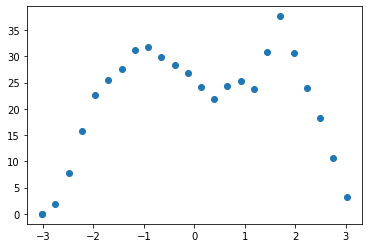

{-3.014055161152975: (0.010115720137164885, nan),
 -2.752055161152975: (1.9745346799450232, nan),
 -2.490055161152975: (7.851089048001654, nan),
 -2.228055161152975: (15.844584141171254, nan),
 -1.9660551611529749: (22.702968381481256, nan),
 -1.7040551611529748: (25.520403658319637, nan),
 -1.4420551611529748: (27.66834477995637, nan),
 -1.1800551611529748: (31.167074014559056, nan),
 -0.9180551611529748: (31.711593379224922, nan),
 -0.6560551611529748: (29.812722423010086, nan),
 -0.3940551611529748: (28.29821372012131, nan),
 -0.13205516115297478: (26.778480200015366, nan),
 0.12994483884702523: (24.12947919014799, nan),
 0.39194483884702525: (21.941696333910983, nan),
 0.6539448388470253: (24.274264821108247, nan),
 0.9159448388470253: (25.289565611833588, nan),
 1.1779448388470253: (23.84693291219221, nan),
 1.4399448388470253: (30.88144970103864, nan),
 1.7019448388470253: (37.636866437461954, nan),
 1.9639448388470253: (30.6065447384671, nan),
 2.2259448388470253: (24.0326748385

In [14]:
# THR->ALA -- THR at state 0 (lambda = 1)
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16 ,17, 18, 19]) 

INFO:REST:No MonteCarloBarostat added.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:root:Rotating by -0.010295309860492097 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2620000000000006 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26200000000000007 radians
INFO:root:Rotating by 0.2619999999999999 

-5.422062446746905
3.0071301
-20.516004688455258
-20.517175574114283
-19.74933273824695
-17.855413604748975
-15.578664774573575
-13.745784188563547
-12.991760859425755
-12.712272710563532
-12.121088166529258
-11.570476225669548
-11.106079164723349
-10.43797417206174
-10.065974530577362
-10.562670364920614
-11.688266107122622
-12.600898276456567
-13.621960005571742
-14.270050520535591
-13.36865256067311


INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by -6.021185307179586 radians


-12.403829037514505
-12.901792828996193
-13.863672619003667
-15.495129986439485
-17.716285567164288
-19.731523163066207
raw d: {-3.014055161152975: (-20.517175574114283, nan), -2.752055161152975: (-19.74933273824695, nan), -2.490055161152975: (-17.855413604748975, nan), -2.228055161152975: (-15.578664774573575, nan), -1.9660551611529749: (-13.745784188563547, nan), -1.7040551611529748: (-12.991760859425755, nan), -1.4420551611529748: (-12.712272710563532, nan), -1.1800551611529748: (-12.121088166529258, nan), -0.9180551611529748: (-11.570476225669548, nan), -0.6560551611529748: (-11.106079164723349, nan), -0.3940551611529748: (-10.43797417206174, nan), -0.13205516115297478: (-10.065974530577362, nan), 0.12994483884702523: (-10.562670364920614, nan), 0.39194483884702525: (-11.688266107122622, nan), 0.6539448388470253: (-12.600898276456567, nan), 0.9159448388470253: (-13.621960005571742, nan), 1.1779448388470253: (-14.270050520535591, nan), 1.4399448388470253: (-13.36865256067311, nan), 

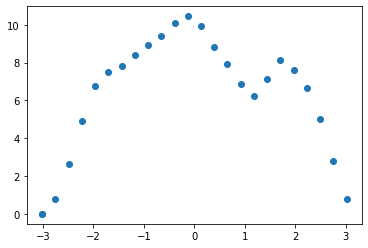

{-3.014055161152975: (0.0, nan),
 -2.752055161152975: (0.7678428358673344, nan),
 -2.490055161152975: (2.6617619693653083, nan),
 -2.228055161152975: (4.938510799540708, nan),
 -1.9660551611529749: (6.771391385550736, nan),
 -1.7040551611529748: (7.525414714688528, nan),
 -1.4420551611529748: (7.804902863550751, nan),
 -1.1800551611529748: (8.396087407585025, nan),
 -0.9180551611529748: (8.946699348444735, nan),
 -0.6560551611529748: (9.411096409390934, nan),
 -0.3940551611529748: (10.079201402052544, nan),
 -0.13205516115297478: (10.451201043536921, nan),
 0.12994483884702523: (9.95450520919367, nan),
 0.39194483884702525: (8.82890946699166, nan),
 0.6539448388470253: (7.916277297657716, nan),
 0.9159448388470253: (6.895215568542541, nan),
 1.1779448388470253: (6.247125053578692, nan),
 1.4399448388470253: (7.148523013441173, nan),
 1.7019448388470253: (8.113346536599778, nan),
 1.9639448388470253: (7.61538274511809, nan),
 2.2259448388470253: (6.653502955110616, nan),
 2.487944838847

In [18]:
# THR->ALA -- THR at state 11 (temp = 600)
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16 ,17, 18, 19]) 

## THR->ALA r-htf in solvent (flattened torsions and exceptions) @ lambda = 0, REST2 @ 1200K

In [7]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/11/7/"

with open(os.path.join(data_dir, f"7_solvent_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)


In [8]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-C 0
ACE1-O 1
ACE1-CH3 2
ACE1-H1 3
ACE1-H2 4
ACE1-H3 5
THR2-N 6
THR2-CA 7
THR2-C 8
THR2-O 9
THR2-CB 10
THR2-CG2 11
THR2-OG1 12
THR2-H 13
THR2-HA 14
THR2-HB 15
THR2-HG1 16
THR2-HG21 17
THR2-HG22 18
THR2-HG23 19
THR2-CB 1549
THR2-HB1 1550
THR2-HB2 1551
THR2-HB3 1552
NME3-N 20
NME3-C 21
NME3-H 22
NME3-H1 23
NME3-H2 24
NME3-H3 25
HOH4-O 26
HOH4-H1 27
HOH4-H2 28
HOH5-O 29
HOH5-H1 30
HOH5-H2 31
HOH6-O 32
HOH6-H1 33
HOH6-H2 34
HOH7-O 35
HOH7-H1 36
HOH7-H2 37
HOH8-O 38
HOH8-H1 39
HOH8-H2 40
HOH9-O 41
HOH9-H1 42
HOH9-H2 43
HOH10-O 44
HOH10-H1 45
HOH10-H2 46
HOH11-O 47
HOH11-H1 48
HOH11-H2 49
HOH12-O 50
HOH12-H1 51
HOH12-H2 52
HOH13-O 53
HOH13-H1 54
HOH13-H2 55
HOH14-O 56
HOH14-H1 57
HOH14-H2 58
HOH15-O 59
HOH15-H1 60
HOH15-H2 61
HOH16-O 62
HOH16-H1 63
HOH16-H2 64
HOH17-O 65
HOH17-H1 66
HOH17-H2 67
HOH18-O 68
HOH18-H1 69
HOH18-H2 70
HOH19-O 71
HOH19-H1 72
HOH19-H2 73
HOH20-O 74
HOH20-H1 75
HOH20-H2 76
HOH21-O 77
HOH21-H1 78
HOH21-H2 79
HOH22-O 80
HOH22-H1 81
HOH22-H2 82
HOH23-O 83
HOH23-H1 8

HOH312-H2 952
HOH313-O 953
HOH313-H1 954
HOH313-H2 955
HOH314-O 956
HOH314-H1 957
HOH314-H2 958
HOH315-O 959
HOH315-H1 960
HOH315-H2 961
HOH316-O 962
HOH316-H1 963
HOH316-H2 964
HOH317-O 965
HOH317-H1 966
HOH317-H2 967
HOH318-O 968
HOH318-H1 969
HOH318-H2 970
HOH319-O 971
HOH319-H1 972
HOH319-H2 973
HOH320-O 974
HOH320-H1 975
HOH320-H2 976
HOH321-O 977
HOH321-H1 978
HOH321-H2 979
HOH322-O 980
HOH322-H1 981
HOH322-H2 982
HOH323-O 983
HOH323-H1 984
HOH323-H2 985
HOH324-O 986
HOH324-H1 987
HOH324-H2 988
HOH325-O 989
HOH325-H1 990
HOH325-H2 991
HOH326-O 992
HOH326-H1 993
HOH326-H2 994
HOH327-O 995
HOH327-H1 996
HOH327-H2 997
HOH328-O 998
HOH328-H1 999
HOH328-H2 1000
HOH329-O 1001
HOH329-H1 1002
HOH329-H2 1003
HOH330-O 1004
HOH330-H1 1005
HOH330-H2 1006
HOH331-O 1007
HOH331-H1 1008
HOH331-H2 1009
HOH332-O 1010
HOH332-H1 1011
HOH332-H2 1012
HOH333-O 1013
HOH333-H1 1014
HOH333-H2 1015
HOH334-O 1016
HOH334-H1 1017
HOH334-H2 1018
HOH335-O 1019
HOH335-H1 1020
HOH335-H2 1021
HOH336-O 1022
HOH336-

In [9]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (CA) of chain 0 residue 1 (THR)> 7
<Atom 8 (C) of chain 0 residue 1 (THR)> 8
<Atom 9 (O) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (CG2) of chain 0 residue 1 (THR)> 11
<Atom 12 (OG1) of chain 0 residue 1 (THR)> 12
<Atom 13 (H) of chain 0 residue 1 (THR)> 13
<Atom 14 (HA) of chain 0 residue 1 (THR)> 14
<Atom 15 (HB) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG1) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG21) of chain 0 residue 1 (THR)> 17
<Atom 18 (HG22) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG23) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (C) of chain 0 residue 2 (NME)> 21
<Atom 22 (H) of chain 0 resi

<Atom 650 (O) of chain 1 residue 211 (HOH)> 650
<Atom 651 (H1) of chain 1 residue 211 (HOH)> 651
<Atom 652 (H2) of chain 1 residue 211 (HOH)> 652
<Atom 653 (O) of chain 1 residue 212 (HOH)> 653
<Atom 654 (H1) of chain 1 residue 212 (HOH)> 654
<Atom 655 (H2) of chain 1 residue 212 (HOH)> 655
<Atom 656 (O) of chain 1 residue 213 (HOH)> 656
<Atom 657 (H1) of chain 1 residue 213 (HOH)> 657
<Atom 658 (H2) of chain 1 residue 213 (HOH)> 658
<Atom 659 (O) of chain 1 residue 214 (HOH)> 659
<Atom 660 (H1) of chain 1 residue 214 (HOH)> 660
<Atom 661 (H2) of chain 1 residue 214 (HOH)> 661
<Atom 662 (O) of chain 1 residue 215 (HOH)> 662
<Atom 663 (H1) of chain 1 residue 215 (HOH)> 663
<Atom 664 (H2) of chain 1 residue 215 (HOH)> 664
<Atom 665 (O) of chain 1 residue 216 (HOH)> 665
<Atom 666 (H1) of chain 1 residue 216 (HOH)> 666
<Atom 667 (H2) of chain 1 residue 216 (HOH)> 667
<Atom 668 (O) of chain 1 residue 217 (HOH)> 668
<Atom 669 (H1) of chain 1 residue 217 (HOH)> 669
<Atom 670 (H2) of chain 1 r

<Atom 900 (H1) of chain 1 residue 294 (HOH)> 900
<Atom 901 (H2) of chain 1 residue 294 (HOH)> 901
<Atom 902 (O) of chain 1 residue 295 (HOH)> 902
<Atom 903 (H1) of chain 1 residue 295 (HOH)> 903
<Atom 904 (H2) of chain 1 residue 295 (HOH)> 904
<Atom 905 (O) of chain 1 residue 296 (HOH)> 905
<Atom 906 (H1) of chain 1 residue 296 (HOH)> 906
<Atom 907 (H2) of chain 1 residue 296 (HOH)> 907
<Atom 908 (O) of chain 1 residue 297 (HOH)> 908
<Atom 909 (H1) of chain 1 residue 297 (HOH)> 909
<Atom 910 (H2) of chain 1 residue 297 (HOH)> 910
<Atom 911 (O) of chain 1 residue 298 (HOH)> 911
<Atom 912 (H1) of chain 1 residue 298 (HOH)> 912
<Atom 913 (H2) of chain 1 residue 298 (HOH)> 913
<Atom 914 (O) of chain 1 residue 299 (HOH)> 914
<Atom 915 (H1) of chain 1 residue 299 (HOH)> 915
<Atom 916 (H2) of chain 1 residue 299 (HOH)> 916
<Atom 917 (O) of chain 1 residue 300 (HOH)> 917
<Atom 918 (H1) of chain 1 residue 300 (HOH)> 918
<Atom 919 (H2) of chain 1 residue 300 (HOH)> 919
<Atom 920 (O) of chain 1 r

<Atom 1399 (H2) of chain 1 residue 460 (HOH)> 1399
<Atom 1400 (O) of chain 1 residue 461 (HOH)> 1400
<Atom 1401 (H1) of chain 1 residue 461 (HOH)> 1401
<Atom 1402 (H2) of chain 1 residue 461 (HOH)> 1402
<Atom 1403 (O) of chain 1 residue 462 (HOH)> 1403
<Atom 1404 (H1) of chain 1 residue 462 (HOH)> 1404
<Atom 1405 (H2) of chain 1 residue 462 (HOH)> 1405
<Atom 1406 (O) of chain 1 residue 463 (HOH)> 1406
<Atom 1407 (H1) of chain 1 residue 463 (HOH)> 1407
<Atom 1408 (H2) of chain 1 residue 463 (HOH)> 1408
<Atom 1409 (O) of chain 1 residue 464 (HOH)> 1409
<Atom 1410 (H1) of chain 1 residue 464 (HOH)> 1410
<Atom 1411 (H2) of chain 1 residue 464 (HOH)> 1411
<Atom 1412 (O) of chain 1 residue 465 (HOH)> 1412
<Atom 1413 (H1) of chain 1 residue 465 (HOH)> 1413
<Atom 1414 (H2) of chain 1 residue 465 (HOH)> 1414
<Atom 1415 (O) of chain 1 residue 466 (HOH)> 1415
<Atom 1416 (H1) of chain 1 residue 466 (HOH)> 1416
<Atom 1417 (H2) of chain 1 residue 466 (HOH)> 1417
<Atom 1418 (O) of chain 1 residue 467

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.5648, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.5648, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.5648), unit=nanometer)]
INFO:REST:No unknown forces.


1292.898585324227
3.0071301
-8750.94551247462


INFO:root:Rotating by -6.120914020146159 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.26200000000000667 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999991 radians


-8721.41655446666
-8558.79674613303
-8548.873584787312
-8555.7932963605
-8650.85240284887
-8488.089810459029
-8602.5506546121
-8633.326993322005
-8677.713674219629
-8550.974397608134


INFO:root:Rotating by 0.2619999999999992 radians
INFO:root:Rotating by 0.2620000000000005 radians
INFO:root:Rotating by 0.26200000000000007 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999989 radians


-8645.193403180505
-8551.040151855988
-8536.479992872288
-8583.968976335738
-8655.86158772476
-8485.471961188894
-8532.930012766026
-8392.225028115261
-8726.043737105078
-8605.722459515691


INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179586 radians


-8480.70064084696
-8660.304969044399
-8835.665535167649
-8843.159979336171
raw d: {-3.014055161152975: (-8721.41655446666, nan), -2.752055161152975: (-8558.79674613303, nan), -2.490055161152975: (-8548.873584787312, nan), -2.228055161152975: (-8555.7932963605, nan), -1.9660551611529749: (-8650.85240284887, nan), -1.7040551611529748: (-8488.089810459029, nan), -1.4420551611529748: (-8602.5506546121, nan), -1.1800551611529748: (-8633.326993322005, nan), -0.9180551611529748: (-8677.713674219629, nan), -0.6560551611529748: (-8550.974397608134, nan), -0.3940551611529748: (-8645.193403180505, nan), -0.13205516115297478: (-8551.040151855988, nan), 0.12994483884702523: (-8536.479992872288, nan), 0.39194483884702525: (-8583.968976335738, nan), 0.6539448388470253: (-8655.86158772476, nan), 0.9159448388470253: (-8485.471961188894, nan), 1.1779448388470253: (-8532.930012766026, nan), 1.4399448388470253: (-8392.225028115261, nan), 1.7019448388470253: (-8726.043737105078, nan), 1.9639448388470253: (

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


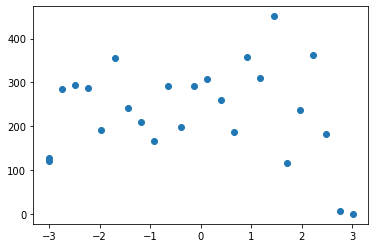

{-3.014055161152975: (121.74342486951173, nan),
 -2.752055161152975: (284.36323320314114, nan),
 -2.490055161152975: (294.2863945488589, nan),
 -2.228055161152975: (287.3666829756712, nan),
 -1.9660551611529749: (192.30757648730105, nan),
 -1.7040551611529748: (355.07016887714235, nan),
 -1.4420551611529748: (240.60932472407148, nan),
 -1.1800551611529748: (209.83298601416573, nan),
 -0.9180551611529748: (165.44630511654213, nan),
 -0.6560551611529748: (292.1855817280375, nan),
 -0.3940551611529748: (197.9665761556662, nan),
 -0.13205516115297478: (292.1198274801827, nan),
 0.12994483884702523: (306.6799864638833, nan),
 0.39194483884702525: (259.19100300043283, nan),
 0.6539448388470253: (187.29839161141172, nan),
 0.9159448388470253: (357.68801814727703, nan),
 1.1779448388470253: (310.2299665701448, nan),
 1.4399448388470253: (450.9349512209101, nan),
 1.7019448388470253: (117.11624223109357, nan),
 1.9639448388470253: (237.4375198204798, nan),
 2.2259448388470253: (362.459338489210

In [10]:
# THR->ALA -- THR at state 0 (lambda = 1)
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16 ,17, 18, 19]) 

INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.5648, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.5648, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.5648), unit=nanometer)]
INFO:REST:No unknown forces.


665.3938407745474


INFO:root:Rotating by 0.12200398687775182 radians
INFO:root:Rotating by 0.26199999999999557 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2619999999999992 radians
INFO:root:Rotating by 0.26200000000000134 radians


3.0071301
-4521.355329439014
-4436.882236304537
-4431.995802749982
-4405.874574464559
-4400.192131869234
-4404.492924942045
-4409.837504666166
-4406.108976568351
-4433.353796137578
-4439.519189332004
-4379.76193345522
-4394.374592644882
-4395.7930333336035


INFO:root:Rotating by 0.26199999999999923 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179586 radians


-4388.246118307008
-4372.612819702386
-4454.173851034698
-4431.823740871727
-4416.200744824967
-4371.951008186855
-4399.016325920478
-4405.395661721279
-4388.243612996535
-4451.973013558558
-4516.288998357264
-4525.980951930017
raw d: {-3.014055161152975: (-4436.882236304537, nan), -2.752055161152975: (-4431.995802749982, nan), -2.490055161152975: (-4405.874574464559, nan), -2.228055161152975: (-4400.192131869234, nan), -1.9660551611529749: (-4404.492924942045, nan), -1.7040551611529748: (-4409.837504666166, nan), -1.4420551611529748: (-4406.108976568351, nan), -1.1800551611529748: (-4433.353796137578, nan), -0.9180551611529748: (-4439.519189332004, nan), -0.6560551611529748: (-4379.76193345522, nan), -0.3940551611529748: (-4394.374592644882, nan), -0.13205516115297478: (-4395.7930333336035, nan), 0.12994483884702523: (-4388.246118307008, nan), 0.39194483884702525: (-4372.612819702386, nan), 0.6539448388470253: (-4454.173851034698, nan), 0.9159448388470253: (-4431.823740871727, nan), 1

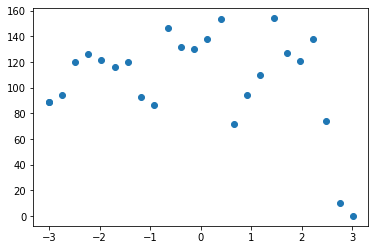

{-3.014055161152975: (89.0987156254796, nan),
 -2.752055161152975: (93.98514918003457, nan),
 -2.490055161152975: (120.10637746545763, nan),
 -2.228055161152975: (125.78882006078311, nan),
 -1.9660551611529749: (121.48802698797226, nan),
 -1.7040551611529748: (116.14344726385116, nan),
 -1.4420551611529748: (119.87197536166605, nan),
 -1.1800551611529748: (92.62715579243923, nan),
 -0.9180551611529748: (86.46176259801268, nan),
 -0.6560551611529748: (146.21901847479694, nan),
 -0.3940551611529748: (131.6063592851351, nan),
 -0.13205516115297478: (130.1879185964135, nan),
 0.12994483884702523: (137.73483362300885, nan),
 0.39194483884702525: (153.36813222763067, nan),
 0.6539448388470253: (71.80710089531931, nan),
 0.9159448388470253: (94.15721105829016, nan),
 1.1779448388470253: (109.78020710505007, nan),
 1.4399448388470253: (154.02994374316222, nan),
 1.7019448388470253: (126.96462600953873, nan),
 1.9639448388470253: (120.58529020873812, nan),
 2.2259448388470253: (137.737338933481

In [12]:
# THR->ALA -- THR at state 11 (temp = 600)
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16 ,17, 18, 19]) 

# Vanilla ala solvated system

In [ ]:
# Define simulation parameters
nsteps = 10000
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
collision_rate = 1.0 / unit.picoseconds

system = pickle.load(f, open("/data/chodera/zhangi/perses_benchmark/neq/11", "rb"))
positions = htf.hybrid_positions

# Build REST factory
factory = RESTTopologyFactory(system, solute_region=list(range(6, 20)) + [0, 1, 20, 22])

# Get REST system
REST_system = factory.REST_system

# Create thermostate
T_min = 298.0*unit.kelvin
temperature = 600.0*unit.kelvin
lambda_zero_alchemical_state = RESTState.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=temperature)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1/(kB*T_min)
beta_m = 1/(kB*temperature)
compound_thermodynamic_state.set_alchemical_parameters(beta_0, beta_m)

# Create sampler state
sampler_state =  SamplerState(positions, box_vectors=system.getDefaultPeriodicBoxVectors())

# Set up integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')

context = compound_thermodynamic_state.create_context(integrator, platform=platform)    

context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)
print(compound_thermodynamic_state.reduced_potential(context))

#     md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

#     # Run equilibration
#     for step in tqdm(range(nsteps)):
#         integrator.step(1)

return context, compound_thermodynamic_state